# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***
$Q=\sum_{n=1}^{N} \sum_{k=1}^{K} r_{n, k}\left\|x_{n}-\mu_{k}\right\|^{2}$ - оптимизируемый функционал 

Назовем разбиением $R$ совокупность $r_{n, k}$. В всего имеется $k^N$ различных разбиений, значит за $k^N$ шагов ($k^N + 1$ состояний) будут существовать два разбиения $R_{i}$ и $R_{j}$, такие что $R_{i} = R_{j}$, $i < j$.

Покажем что функционал убывает от состояния к состоянию(если состояния различны) при шаге нашего алгоритма: 

Е-шаг: $\mu_{k}$ - фиксированны, тогда очевидно, что $Q=\sum_{n=1}^{N} \sum_{k=1}^{K} r_{n, k}\left\|x_{n}-\mu_{k}\right\|^{2}$ - минимален, когда каждое слагаемое $\sum_{k=1}^{K}\left\|x_{n}-\mu_{k}\right\|^{2}$ - минимально, именно в это состояние мы приводим функционал на данном шаге - относим, объект к ближайшему кластеру. Таким образом если мы поменяли принадлежность хоть одного объекта функционал уменьшился.

М-шаг: теперь $r_{n, k}$ - фиксированны, рассмотрим $K_{i}$ - некий кластер: $\sum_{n \in K_{i}} \left\|x_{n}-\mu_{i}\right\|^{2}$ - данная функционал минимален, если $\mu_{i}$ - барицентр, и именно к барицентру наш алгоритм приводит точку $\mu_{i}$, т.к. по сути после преобразования $\mu_{i_{new}}=\frac{\mathbf{x}_{1}+\mathbf{x}_{2}+\cdots+\mathbf{x}_{k}}{k}, x_{k} \in K_{i}$. Значит, если $\mu_{i}$ изначально не совпадал с барицентром, то после преобразования значение функционала уменьшилось.

Значит после обоих шагов алгоритма расстояние уменьшилось, и не изменилось только в том случае если не изменилось разбиение, значит что каждому разбиению можно сопоставить число равное значентию функционала потерь при данном разбиении(центр кластера ссовпадает с барицентром).

Значит, если $R_{i}$ и $R_{j}$ идут подряд, значит система стабилизировалась. А метод сошелся.

Задача 2.  ММП для многомерного нормального распределения.

Функция правдоподобия в общем случае записывается как:
￼
￼$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$
￼

***Ваше решение здесь***

￼$$ ln(L(\theta)) = ln(p(X | \theta )) = ln(\prod_{i=1}^N p(x_i | \theta)) = \sum_{i=1}^N ln(p(x_i | \theta)) $$
$$ ln(L(\theta)) = \sum_{i=1}^N ln\frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}   - {-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)} $$
$$ \frac {\partial{lnL(\theta))}}{\partial{\mu}}  = -\frac{1}{2}\sum_{i=1}^N \frac{\partial}{\partial{\mu}} (x_i^T\Sigma^{-1}x_i - x_i^T \Sigma^{-1} \mu -\mu^T \Sigma^{-1} x_i+ \mu^T\Sigma^{-1} \mu ) = 0 $$

$$ \frac {\partial{lnL(\theta))}}{\partial{\mu}} = -\frac{1}{2}\sum_{i=1}^N(-\Sigma^{-1}x_i - (x_i^T\Sigma^{-1})^{T})  + N(\Sigma^{-1}\mu +(\mu_i^T\Sigma^{-1})^T) = 0$$
 
$$N(\Sigma^{-1} +(\Sigma^{-1})^T)\mu  =  \sum_{i=1}^N(\Sigma^{-1} +(\Sigma^{-1})^T)x_i$$

$$ \mu = \frac{1}{N} (\Sigma^{-1} +(\Sigma^{-1})^T)^{-1}(\Sigma^{-1} +(\Sigma^{-1})^T) \sum_{i=1}^N x_i$$
$$ \mu = \frac{1}{N} \sum_{i=1}^N x_i $$

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***


$d_{\max}(U \cup V, S)=\max(d_{\max}(U, S),d_{\max}(V, S))$
$=\frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |$
$d_{\min}(U \cup V, S)=\min(d_{\min}(U, S),d_{\min}(V, S))$
$=\frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |$

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [15]:
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.cluster.hierarchy import dendrogram
from copy import deepcopy

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self,n_clusters = 2, metric = 'euclidean', linkage='single', **kwargs):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clusters=n_clusters
        self.metric=metric
        self.linkage=linkage
        
        if metric == 'euclidean':
            self.dist = distance.euclidean
        if metric == 'manhattan':
            self.dist = distance.cityblock
        if metric == 'cosine':
            self.dist = distance.cosine
        if metric == 'minkowski':
            self.dist = distance.minkowski

        if linkage == 'single':
            self.a_i = 1/2.
            self.a_j = 1/2.
            self.c = -1/2.
        elif linkage == 'complete':
            self.a_i = 1/2.
            self.a_j = 1/2.
            self.c = 1/2.
        elif linkage == 'average':
            self.c = 0

        return
        
    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        self.x_len = len(x)
        dist_matrix = np.matrix([[self.dist(x[i],x[j]) if i!=j else np.inf \
                                  for i in range(self.x_len)] for j in range(self.x_len)])
        self.history = []
        self.n_steps = self.x_len-1
        self.clusts = [[i] for i in range(self.x_len)]
        self.cl = deepcopy(self.clusts)
        
        
        for i in range(self.n_steps):
            if i == self.x_len-self.n_clusters:
                self.clusters = deepcopy(self.clusts)
                
            ind = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
            
            C_i= self.clusts[ind[0]]
            C_j = self.clusts[ind[1]]
            C_ij = C_i+C_j
            
            self.clusts.remove(C_i)
            self.clusts.remove(C_j)
            self.clusts.append(C_ij)
            self.cl.append(C_ij)
            
            self.history.append([self.cl.index(C_i), self.cl.index(C_j), \
                           dist_matrix[ind[0],ind[1]], len(C_i)+len(C_j)])
            
            if self.linkage =='average':
                denominator = len(C_i) + len(C_j)
                self.a_i = len(C_i) / denominator
                self.a_j = len(C_j) / denominator
                
            new_dist0 = np.ones(dist_matrix.shape[0])
            new_dist1 = np.ones(dist_matrix.shape[0]+1)
            
            for k in range(dist_matrix.shape[0]):
                new_dist0[k] = new_dist1[k]=self.a_i*dist_matrix[ind[0],k] + self.a_j*dist_matrix[ind[1],k] +\
                                self.c*abs(dist_matrix[ind[0],k] - dist_matrix[ind[1],k])
                if k in ind:
                    new_dist0[k]=new_dist1[k]=np.inf
                    
            new_dist1[dist_matrix.shape[0]] = np.inf
            new_dist0 = np.expand_dims(new_dist0, axis=1)
            dist_matrix = np.concatenate((dist_matrix, new_dist0), 1)
            new_dist1 = np.expand_dims(new_dist1, axis=0)
            dist_matrix = np.concatenate((dist_matrix, new_dist1), 0)
            dist_matrix = np.delete(dist_matrix,(ind[0],ind[1]), 0)
            dist_matrix = np.delete(dist_matrix,(ind[0],ind[1]), 1)
            
        self.history=np.array(self.history, dtype='float64')
        clusters_labels = np.ones(self.x_len, dtype=int)
        for cluster_number, number in enumerate(self.clusters):
            clusters_labels[number] = cluster_number
            
        return clusters_labels
    
    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        plt.figure(figsize = (16, 8))
        dendrogram(self.history)
        pass

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

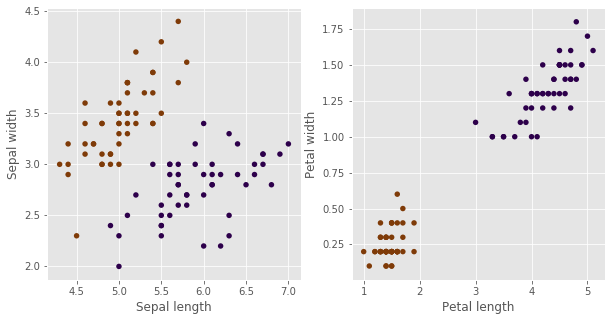

In [16]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [17]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))


 Sklearn AGGL score 1.0. Sklearn AGGL time 0.002679109573364258


Our AGGL score 1.0. Our AGGL time 0.2276620864868164


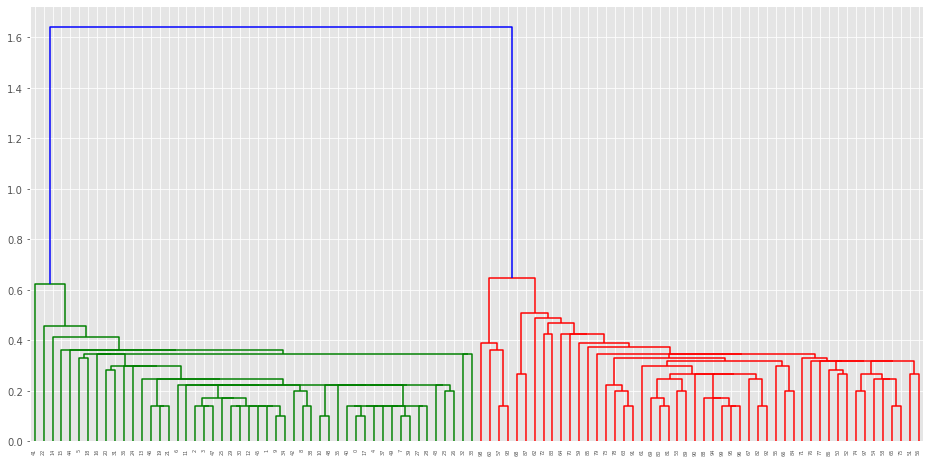

In [18]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='euclidean', n_clusters=2)
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))
сustum_aggl.plot_dendrogram()

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

In [19]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [20]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))
len(traingroups_titledata)    

129

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [24]:
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import chain
my_aggl=Clustering(n_clusters=2, metric='cosine', linkage ='average' )
x=[]
y=[]
Y=[]
Y_PRED=[]
for j in range(1,130):
    x.clear()
    y.clear()
    for i in range(len(traingroups_titledata[j])):
        x.append(traingroups_titledata[j][i][1])
        y.append(traingroups_titledata[j][i][2])
        Y.append(traingroups_titledata[j][i][2])
    x_train = TfidfVectorizer(ngram_range=(1,3)).fit_transform(x)
    x_train = x_train.toarray()
    y_pred = my_aggl.fit_predict(x_train)
    Y_PRED.append(y_pred) 
    print('f1_score для группы {} = {}'.format(j, f1_score(y, y_pred)))
Y_PRED = list(chain(*Y_PRED))    
print(f1_score(Y,Y_PRED))

f1_score для группы 1 = 0.0
f1_score для группы 2 = 0.26
f1_score для группы 3 = 0.1978021978021978
f1_score для группы 4 = 0.15384615384615385
f1_score для группы 5 = 0.0
f1_score для группы 6 = 0.08333333333333333
f1_score для группы 7 = 0.1414141414141414
f1_score для группы 8 = 0.0
f1_score для группы 9 = 0.09523809523809525
f1_score для группы 10 = 0.0
f1_score для группы 11 = 0.0
f1_score для группы 12 = 0.1904761904761905
f1_score для группы 13 = 0.6666666666666666
f1_score для группы 14 = 0.0
f1_score для группы 15 = 0.0
f1_score для группы 16 = 0.6666666666666666
f1_score для группы 17 = 0.8275862068965517
f1_score для группы 18 = 0.0
f1_score для группы 19 = 0.12499999999999999
f1_score для группы 20 = 0.0
f1_score для группы 21 = 0.0
f1_score для группы 22 = 0.9316770186335404
f1_score для группы 23 = 0.7310344827586207
f1_score для группы 24 = 0.6666666666666666
f1_score для группы 25 = 0.02666666666666666
f1_score для группы 26 = 0.9605263157894737
f1_score для группы 27 =

In [25]:
print(f1_score(Y,Y_PRED))

0.4637408174797513


Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***